In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
df = pd.read_csv('online_behaviour.csv')
df = df.dropna()
df.head(2)

,UserID,session_time_seconds,top_banner_image_click,last_minute_deals_click,best_sellers_click,christmas_menu_click,new_releases_click,product_image_click,frequently_bought _together_click,more_items_click,reviews_click,subscribe_save_click,one_time_checkout,add_to_basket,returning_user,purchased,repeat_purchaser
0,a720-6b732349-a720-4862-bd21-644732,100,0,0,0,0,0,0,0,0,1,0,0,0.00000,0,0,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,5,0,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0


# 1. Which of the website interactions are highly correlated with a user’s likelihood (propensity) to purchase?

In [4]:
# Cleaning data, UserID is irrelevant and not numerical
df = df.drop('UserID', axis=1)

## attempt 1:
# for row in correlation:
#     if row > 0.1:
#         high_correlation.append(("{:10.2f}".format(row * 100)))


correlation = df.corr()['purchased']


# Top five are above 10%
correlation.nlargest(5)

purchased              1.00000
new_releases_click     0.41310
subscribe_save_click   0.17267
add_to_basket          0.15280
repeat_purchaser       0.12430
Name: purchased, dtype: float64

# 2. Which of the website interactions are highly correlated with a user’s likelihood (propensity) to repeat purchase?

In [5]:
correlation = df.corr()['repeat_purchaser']

# Top five are above 10%
correlation.nlargest(7)

repeat_purchaser          1.00000
best_sellers_click        0.35807
last_minute_deals_click   0.21061
purchased                 0.12430
session_time_seconds      0.10995
one_time_checkout         0.09358
add_to_basket             0.07443
Name: repeat_purchaser, dtype: float64

# 3. Predict how likely new customers are to buy based on a new test model (also test the accuracy of the model).

In [6]:
# Only using *new* users
df2 = df[df.returning_user != 1]
df2 = df2[df2.repeat_purchaser != 1]

correlation = df2.corr()['purchased']
correlation.nlargest(7)

purchased                           1.00000
new_releases_click                  0.49880
add_to_basket                       0.23347
frequently_bought _together_click   0.18750
product_image_click                 0.08129
subscribe_save_click                0.06828
christmas_menu_click                0.06100
Name: purchased, dtype: float64

In [7]:
# I take any value over 10%
# Pulling out our most highly correlated values
# Only including things that can be clicked
predictors = df[['new_releases_click','add_to_basket','frequently_bought _together_click', 'product_image_click']]
# # What we want our model to target
targets = df.purchased
predictors.head(3)

,new_releases_click,add_to_basket,frequently_bought _together_click,product_image_click
0,0,0.00000,0,0
1,0,0.00000,0,0
2,0,0.00000,0,0


In [8]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.3)
print('Predictor - Training: ',pred_train.shape, 'Predictor - Testing: ', pred_test.shape)
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier = classifier.fit(pred_train, tar_train)
predictions = classifier.predict(pred_test)

# Generating a model to predict how likely someone is to buy based on our test data
pred_prob = classifier.predict_proba(pred_test)

Predictor - Training:  (1244, 4) Predictor - Testing:  (534, 4)


In [9]:
# Find out how accurate our model is
sklearn.metrics.accuracy_score(tar_test, predictions).round(2)

0.71

In [74]:
# 60% chance of buying
pred_prob = classifier.predict_proba(pred_test)

# 0 = chance the first user will buy, 1 = chance of not buying
pred_prob[0,1].round(2)

# :,0 gets first column only (all users' chance to buy)
pred_prob[:,0].mean()

# So mean of column 0 is how likely any new user is to buy something

0.6057848809908433

# 4. Based on real-time use of your model, decide whether a prospect has a propensity to convert for each website column clicked

In [11]:
prospect = pred_prob[0,1]

In [12]:
# Not including a prediction for [0,0,0,0], since one of our columns is 'add_to_basket'
# Wouldn't make sense for a user to have clicked nothing, yet still bought something

new_releases_click = np.array([1,0,0,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(new_releases_click)[:,1])

New visitor - propensity to buy:  [0.51097803]


C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [13]:
add_to_basket_click = np.array([0,1,0,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(add_to_basket_click)[:,1])

New visitor - propensity to buy:  [0.18867381]


C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [14]:
frequently_bought_together_click = np.array([0,0,1,0]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(frequently_bought_together_click)[:,1])

New visitor - propensity to buy:  [0.15964779]


C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [15]:
product_image_click = np.array([0,0,0,1]).reshape(1,-1)
print('New visitor - propensity to buy: ', classifier.predict_proba(product_image_click)[:,1])

New visitor - propensity to buy:  [0.09557522]


C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


# 5. Plot any graph (or add extra code) that would help MegaStore Ltd management interpret their click behaviour data.

C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Jake\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


([<matplotlib.patches.Wedge at 0x27ad445e3d0>,
 [Text(-0.14316475034627824, 1.292092819521217, 'new releases'),
  Text(-0.733021726844835, -0.8201701945166114, 'add to basket'),
  Text(0.44516946686642483, -1.0058946991459212, 'frequently bought together'),
  Text(1.0460640207071679, -0.3402206116359704, 'product image')],
 [Text(-0.0881013848284789, 0.7951340427822874, '53.5%'),
  Text(-0.3998300328244554, -0.4473655606454244, '19.8%'),
  Text(0.24281970919986806, -0.5486698358977751, '16.7%'),
  Text(0.5705803749311824, -0.18557487907416567, '10.0%')])

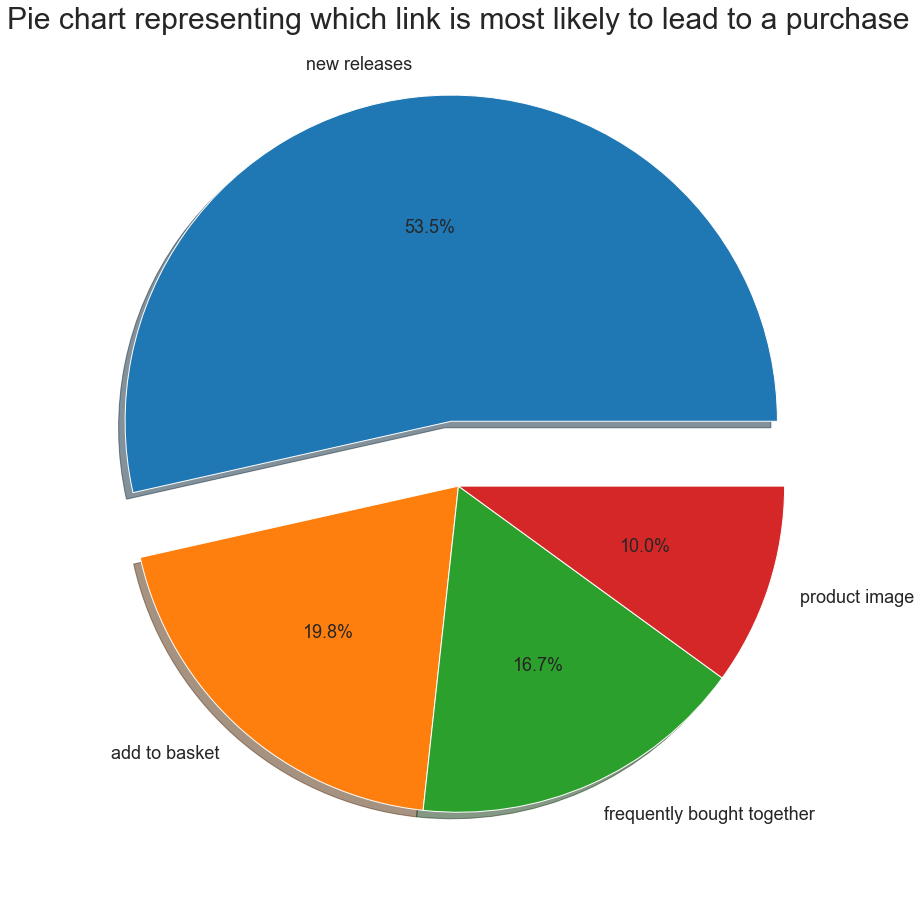

In [29]:
# Pie chart more suitable than bar chart. This is continuous data (number of clicks).
arr = [new_releases_click, add_to_basket_click, frequently_bought_together_click, product_image_click]
correlations = []

for x in range(4):
    correlations.append(classifier.predict_proba(arr[x])[:,1][0])

labels = ['new releases', 'add to basket', 'frequently bought together', 'product image']
sizes = [15, 30, 45, 10]

correlations = np.array(correlations)

# Separating to show off that this is the most significant
explode_releases = [0.2, 0, 0, 0]


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.title('Pie chart representing which link is most likely to lead to a purchase', fontsize=30, pad=50)

# Autopct automatically labels our percentages, textprops to increase fontsize
# Normalising values to always make a full pie
plt.pie(correlations, labels=labels, explode=explode_releases, shadow=True,textprops={'fontsize': 18}, normalize=True)

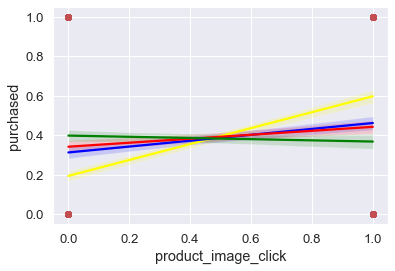

In [73]:
# use Seaborn regplot to show a scatterplot of highest correlated value.
sn.regplot(x=df["new_releases_click"], y=df["purchased"], line_kws={"color": "yellow"})
sn.regplot(x=df["add_to_basket"], y=df["purchased"], line_kws={"color": "blue"})
sn.regplot(x=df["frequently_bought _together_click"], y=df["purchased"], line_kws={"color": "red"})
sn.regplot(x=df["product_image_click"], y=df["purchased"], line_kws={"color": "green"})
sn.set_theme(font_scale=1.2)


## Again, we can see the highest correlated value is new_releases_click, in yellow